In [1]:
from fastapi import FastAPI, File, UploadFile
from fastapi.encoders import jsonable_encoder
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from starlette.middleware.cors import CORSMiddleware
import json
from yahoofinancials import YahooFinancials as YF
import time
import datetime
import pandas as pd
from pandas_datareader import data
from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
import scipy.stats as sp
from utils import *
from pydantic import BaseModel
from backtester import *
from backtest import *
import matplotlib.pyplot as plt
import quandl



In [2]:
path = r"C:\Users\moyer\OneDrive\development\stocks.pkl"
stocks = {}
tickers = ['T','MSFT','AAPL']
days_back = 100
with open(path, "rb") as pkl_handle:
    stocks = pickle.load(pkl_handle)
    for ticker in tickers:   
        stocks[ticker] = stocks[ticker].tail(days_back)

In [3]:
stock = Stock(stocks['AAPL'], 'AAPL')
stock.ticker
params1 = {
    'AAPL': 1,
}
params2 = {
    'AAPL': 0.33,
}
macd_params = {
    'AAPL': {
        'short': 13,
        'long':21
    },
}
markowtiz_params = {
    'tickers': ['AAPL']
}
strats = [
    stock.buyWeights(params=params1),
    stock.buyWeights(params=params2),
    stock.macd(macd_params),
    # stock.markowitz(markowtiz_params)
]
stock.strategies = strats
stock.backtest()
stock.positions




,AAPL,AAPL_position,AAPL_pos_diff,AAPL_cash,AAPL_holdings,AAPL_open,AAPL_close,holdings,cash_diff,cash,total,returns,date
Date,,,,,,,,,,,,,
2021-08-25,0.265543,0.265543,0.000000,0.000000,39.780947,149.809998,148.360001,39.780947,0.000000,1000.000000,1039.780947,0.000000,08/25/2021
2021-08-26,1.587799,1.587799,1.322256,196.156670,235.549928,148.350006,147.539993,235.549928,196.156670,803.843330,1039.393257,-0.000373,08/26/2021
2021-08-27,1.591876,1.591876,0.004077,0.601286,234.769813,147.479996,148.600006,234.769813,0.601286,803.242043,1038.011856,-0.001329,08/27/2021
2021-08-30,1.637787,1.637787,0.045912,6.840825,244.030296,149.000000,153.119995,244.030296,6.840825,796.401218,1040.431514,0.002331,08/30/2021
2021-08-31,1.660831,1.660831,0.023044,3.517869,253.542473,152.660004,151.830002,253.542473,3.517869,792.883348,1046.425821,0.005761,08/31/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10,1.809076,1.809076,-0.056562,-9.563568,305.878591,169.080002,172.190002,305.878591,-9.563568,772.647046,1078.525637,-0.006547,01/10/2022
2022-01-11,1.789562,1.789562,-0.019515,-3.362752,308.377255,172.320007,175.080002,308.377255,-3.362752,776.009798,1084.387054,0.005435,01/11/2022
2022-01-12,1.776092,1.776092,-0.013470,-2.372317,312.805251,176.119995,175.529999,312.805251,-2.372317,778.382115,1091.187366,0.006271,01/12/2022


Optimum
{'AAPL': 152.58934419635207, 'MSFT': 4.08363964421468, 'T': 43.32701615943325}


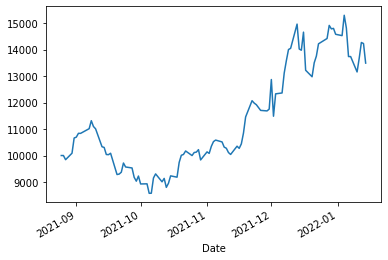

In [8]:

port = Portfolio(stocks,10000);
port.stocks = [Stock(stocks[x], x,port.initial_capital/len(tickers)) for x in tickers]
markowtiz_params = {
    'tickers': ['AAPL', 'T','MSFT'],
    'weight':23
}
strats = [
    port.markowitz(params = markowtiz_params,weight=200)
]
port.strategies = strats
port.backtest_portfolio()
# port.positions.head()
port.positions.total.plot()




In [5]:
bars = stocks
portfolio = MyPortfolio(bars, initial_capital=1000)
params1 = {
    'AAPL': 1,
    'T': 0,
    'MSFT': 0
}
params2 = {
    'AAPL': 0.33,
    'T': 0.33,
    'MSFT': 0.33
}
macd_params = {
    'AAPL': {
        'short': 13,
        'long':21
    },
    'T': {
        'short': 13,
        'long':21
    },
}
markowtiz_params = {
    'tickers': ['AAPL','T','MSFT']
}
strats = [
    portfolio.buyWeights(params=params1),
    portfolio.buyWeights(params=params2),
    portfolio.macd(macd_params),
    portfolio.markowitz(markowtiz_params)
]
portfolio.setStrats(strats)
# print(portfolio.strategies)
# portfolio.genSignals([])

portfolio.generate_positions()
portfolio.backtest_portfolio()


AttributeError: 'MyPortfolio' object has no attribute 'buyWeights'

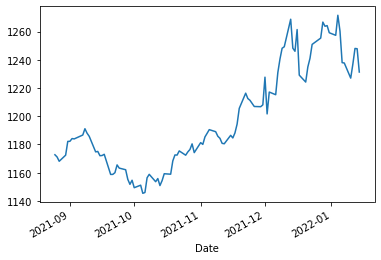

In [5]:
portfolio.positions.total.plot()

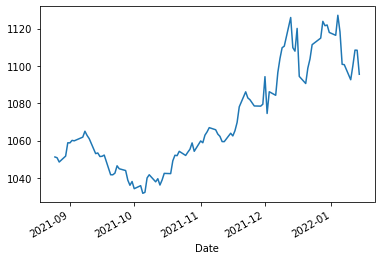

In [12]:
portfolio.positions.total.plot()

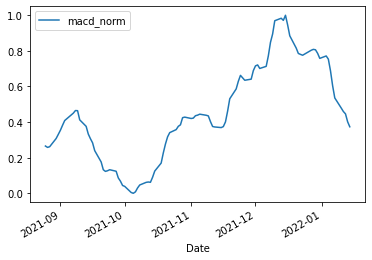

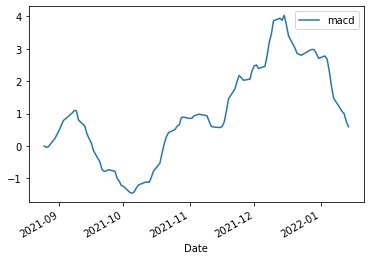

In [9]:
#portfolio.positions[['date','total','AAPL_holdings','AAPL_cash', 'AAPL_open', 'holdings','cash_diff','cash']]
portfolio.bars['AAPL'][['macd_norm']].plot()
portfolio.bars['AAPL'][['macd']].plot()

In [15]:
df = portfolio.bars['AAPL']
exp1 = df['Adj Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['exp1'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['exp2'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1-exp2
df['macd_signal'] = df['macd'].ewm(
    span=9, adjust=False).mean()

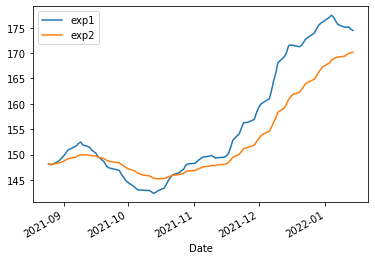

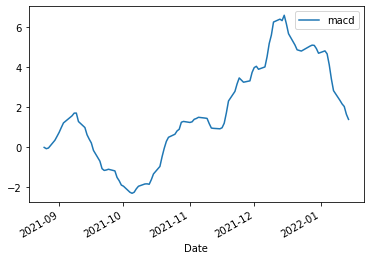

In [16]:
df[['exp1','exp2']].plot()
portfolio.bars['AAPL'][['macd']].plot()

In [4]:
df = pd.DataFrame(index=portfolio.bars[next(iter(portfolio.bars))].index)
bars = addReturns(portfolio.bars, 'Adj Close')
port_returns = getPortReturns(bars)

In [5]:
risk_free = 0
markov_runs = 100
df = pd.DataFrame(columns=["id", "return", "volatility", "weights"])
for x in range(0, int(markov_runs)):
    weights = getRandomWeights(len(tickers))
    volatility = getPortWeightedVol(port_returns, weights)
    ann_ret = getPortWeightedAnnualReturn(port_returns, weights)
    row = {
        "id": x,
        "return": ann_ret,
        "volatility": volatility,
        "weights": weights
    }
    df = df.append(row, ignore_index=True)
df["sharpe"] = (df["return"] - risk_free) / df["volatility"]

MSR = df.sort_values(by=["sharpe"], ascending=False).head(1)
GMV = df.sort_values(by=["volatility"], ascending=True).head(1)

In [10]:
list(portfolio.bars.keys())[1]

'MSFT'

In [ ]:
GMV

In [12]:
weights = {}
for index, x in enumerate(list(MSR['weights'])[0]):
    print(tickers[index])
    weights[tickers[index]] = x

T
MSFT
AAPL


In [13]:
weights

{'T': 0.6936360833799919,
 'MSFT': 0.07333597497070354,
 'AAPL': 0.23302794164930452}